# Dependencies

In [2]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

# NeuralNet class

In [59]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, layers_d, normalize = True, learning_rate = 0.01, num_iter = 30000, stop_eps = 1e-05, epsilon = 1e-08, betha_1 = 0.9, betha_2 = 0.999, k = 500):
        self.layers_d = layers_d # тут лише приховані шари а 0-го та останнього (з одним нейроном) немає
        self.L = len(self.layers_d) + 1 # кількість шарів нейронів в мережі без урахування вихідного
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.stop_eps = stop_eps
        self.epsilon = epsilon
        self.betha_1 = betha_1
        self.betha_2 = betha_2
        self.k = k
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        '''
        X.shape =  (n, m)
        '''
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
            '''
            m.shape =  (n, 1)
            '''
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
            '''
            s.shape =  (n, 1)
            '''
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self, Z):
        
        x = np.exp(Z)        
        '''
        Z_i.shape  = (n_l, 1)
        x.shape = (n_l, 1)
        '''
        return x / np.sum(x, axis=0, keepdims = True)
    
    def __initialize_parameters(self):
        
        self.parameters = {} 
        # стоврюємо словник зі значеннями W_i та b_i,ключами в якому будуть назви W_1, w_2, ... та b_1, b_2 і т.д
        self.adam = {}
        
            
        for i in range(1, self.L + 1):
            
            self.adam['VdW_' + str(i)] = 0
            self.adam['SdW_' + str(i)] = 0
            
            
            self.adam['Vdb_' + str(i)] = 0            
            self.adam['Sdb_' + str(i)] = 0
            self.parameters['W_' + str(i)] = np.random.randn(self.layers_d[i], self.layers_d[i - 1])* np.sqrt(2/self.layers_d[i - 1])
            '''
            W_i.shape  = (n_l, n_l-1) # (кількість нейронів на поточному шарі, кількість на попередньому)
            '''
            self.parameters['b_' + str(i)] = np.zeros((self.layers_d[i],1))
            '''
            b_i.shape  = (n_l,1) # (кількість нейронів на поточному шарі, 1)
            '''
       
    def __forward_propagation(self, X):
        
        cache = {} # стоврюємо словник зі значеннями Z_i та A_i,ключами в якому будуть назви A_0, A_1, A_2, ... та Z_1, Z_2 і т.д
        cache['A_0'] = X
        
        for i in range(1, self.L):
            cache['Z_' + str(i)] = np.dot(self.parameters['W_' + str(i)], cache['A_' + str(i - 1)]) + self.parameters['b_' + str(i)]
            '''
            Z_i.shape  = (n_l, 1) = (n_l, n_l-1) * (n_l-1, 1) + (n_l,1)
            '''
            cache['A_' + str(i)] = self.__sigmoid(cache['Z_' + str(i)])
            '''
            A_i.shape  = (n_l, 1) = (n_l, 1)
            '''       
        cache['Z_' + str(self.L)] = np.dot(self.parameters['W_' + str(self.L)], cache['A_' + str(self.L - 1)]) + self.parameters['b_' + str(self.L)]
        cache['A_' + str(self.L)] = self.__softmax(cache['Z_' + str(self.L)])
        '''
        функція softmax на останньому кроці 
        ''' 
        return cache['A_' + str(self.L)], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        '''
        J.shape  = sum((1, m) x (1, m) - (1, m) x (1, m)) = sum((1, m)) = (1, 1)
        '''
        return J
        
    def __backward_propagation(self, X, Y, cache):
        
        m = X.shape[1]
        gradients = {}
        
        gradients['dZ_' + str(self.L)] = cache['A_' + str(self.L)] - Y
        '''
        dZ_L.shape  = (1, m) - (1, m) = (1, m)
        '''
        gradients['dW_' + str(self.L)] = (1/m) * np.dot (gradients['dZ_' + str(self.L)], cache['A_' + str(self.L - 1)].T)
        '''
        dW_L.shape  = (1, m) * ((n_l-1, m).T) = (1, m) * (m, n_l-1) = (1, n_l-1)
        '''
        gradients['db_' + str(self.L)] = (1/m) * np.sum(gradients['dZ_' + str(self.L)], axis = 1, keepdims = True)
        '''
        db_L.shape  = sum((1, m)) = (1, 1)
        '''
        
        for i in range(self.L - 1, 0, -1):
            dA_i = np.dot (self.parameters['W_' + str(i + 1)].T, gradients['dZ_' + str(i + 1)])
            '''
            dA_i.shape  = (n_l-1, n_l)*(n_l, m) = (n_l-1, m)
            '''
            gradients['dZ_' + str(i)] = np.multiply(dA_i, cache['A_' + str(i)] * (1 - cache['A_' + str(i)]))
            '''
            dZ_i.shape  = (n_l, m)x(n_l, m) = (n_l, m)
            '''
            gradients['dW_' + str(i)] = (1/m) * np.dot (gradients['dZ_' + str(i)], cache['A_' + str(i - 1)].T)
            '''
            dW_i.shape  = (n_l, m)*((n_l-1, n).T) = (n_l, m)*(m, n_l-1) = (n_l, n_l-1)
            '''
            gradients['db_' + str(i)] = (1/m) * np.sum(gradients['dZ_' + str(i)], axis = 1, keepdims = True)
            '''
            db_i.shape = sum((n_l, m)) = (n_l, 1)
            '''       
        
        return gradients
    
    def __update_parameters(self, gradients, t):
          
        for i in range(1, self.L + 1):            
            
            self.adam['VdW_' + str(i)] = self.betha_1 * self.adam['VdW_' + str(i)] + (1 - self.betha_1) * gradients['dW_' + str(i)]  
            self.adam['SdW_' + str(i)] = self.betha_2 * self.adam['SdW_' + str(i)] + (1 - self.betha_2) * (gradients['dW_' + str(i)]**2)
            
            self.adam['VdW_corr_' + str(i)] = self.adam['VdW_' + str(i)] / (1 - self.betha_1**(t + 1))
            self.adam['SdW_corr_' + str(i)] = self.adam['SdW_' + str(i)] / (1 - self.betha_2**(t + 1))
            
            self.parameters['W_' + str(i)] = self.parameters['W_' + str(i)] - (self.learning_rate * self.adam['VdW_corr_' + str(i)] ) /(self.adam['SdW_corr_' + str(i)]**(0.5) + self.epsilon)
            '''
            #W_i.shape  = (n_l, n_l-1) # (кількість нейронів на поточному шарі, кількість на попередньому)
            '''

            self.adam['Vdb_' + str(i)] =  self.betha_1 * self.adam['Vdb_' + str(i)] + (1 - self.betha_1) * gradients['db_' + str(i)]  
            self.adam['Sdb_' + str(i)] =  self.betha_2 * self.adam['Sdb_' + str(i)] + (1 - self.betha_2) * (gradients['db_' + str(i)]**2)          
            
            self.adam['Vdb_corr_' + str(i)] = self.adam['Vdb_' + str(i)] / (1 - self.betha_1**(t + 1))        
            self.adam['Sdb_corr_' + str(i)] = self.adam['Sdb_' + str(i)] / (1 - self.betha_2**(t + 1))

            self.parameters['b_' + str(i)] = self.parameters['b_' + str(i)] - (self.learning_rate * self.adam['Vdb_corr_' + str(i)]) / (self.adam['Sdb_corr_' + str(i)]**(0.5) + self.epsilon)
            
            '''
            #b_i.shape  = (n_l,1) # (кількість нейронів на поточному шарі, 1)
            '''
            
           
            '''
            self.parameters['W_' + str(i)] -= self.learning_rate * gradients['dW_' + str(i)]
            self.parameters['b_' + str(i)] -= self.learning_rate * gradients['db_' + str(i)]
         '''
           
        
    
    def fit(self, X_vert, Y_vert, print_cost = True):
        X= X_vert.T
        
        n_x = X.shape[0] # визначаємо кількість нейронів у вихідному шарі
                
        lb = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False) 
        # задаємо перетворення приналежності до класів як 0 і 1 відвідно для кожного прикладу 
        #([0, 0, 1] - приклад з класу 2, [1, 0, 0] - приклад з класу 0, [0, 1, 0] - приклад з класу 1)
        lb.fit(Y_vert)
        
        Y = lb.transform(Y_vert).T        
        final_classes = Y.shape[0] # визначаємо кількість нейронів у вихідному шарі
        
        self.layers_d.insert(0, n_x)
        self.layers_d.append(final_classes) 
        '''
        додаємо вхідний та вихідний шари до прихованих 
        і отримуємо клькість всіх шарів нейронної мережі і кількість нейронів на кожному шарі
        '''
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters()
        
        previous_cost = 0;

        for i in range(self.num_iter):
            
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            gradients = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(gradients, i)

            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 100 == 0:
                costs.append(cost)
            if (abs(previous_cost - cost) < self.stop_eps):
                self.k = self.k - 1
                if (self.k == 0):
                    break;
                    
            previous_cost = cost

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()  
            
           
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)    
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        probs = self.predict_proba(X_vert)
        results_bin = (probs == probs.max(axis=1)[:, None]).astype(int)
        '''
        максимальне значення в кожному рядку перетворюємо на 1 а інші задаємо як 0
        наприклад, 
        a = np.array([[0, 1], [2, 2], [4, 3]])
        (a == a.max(axis=1)[:,None]).astype(int)
        
        Результат : 
        array([[0, 1], [1, 1], [1, 0]])
        '''
        return results_bin


# Custom algorithm 

In [14]:
from sklearn.datasets import load_iris
X, Y = load_iris(return_X_y = True)

In [15]:
print(X.shape)

(150, 4)


In [16]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [17]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer(sparse_output=False)

In [18]:
lb = lb.fit(Y) # перетворюємо значення Y масив значеннь з 0 та 1, де 1 - приналежність до відповідного по порядку класу

In [19]:
lb.transform(Y)

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [72]:
cls = NeuralNet([4, 3, 3],normalize = True, learning_rate = 0.05, betha_1 = 0.9, betha_2 = 0.999, num_iter = 10000, stop_eps = 1e-06, epsilon = 1e-08, k = 10)

0-th iteration: 1.995004838221502
100-th iteration: 0.19875718465704184
200-th iteration: 0.08103225797246622
300-th iteration: 0.0714086547918564
400-th iteration: 0.0689058219121147
500-th iteration: 0.06778966195429237
600-th iteration: 0.06713457246884867
700-th iteration: 0.06651491235186999
800-th iteration: 0.06219930424421915
900-th iteration: 0.04873081652924523
1000-th iteration: 0.04047465855314599
1100-th iteration: 0.03691879525600805
1200-th iteration: 0.035729902009924173
1300-th iteration: 0.03510743347346718
1400-th iteration: 0.034722814957680884
1500-th iteration: 0.034462817786295834
1600-th iteration: 0.03427613942823977
1700-th iteration: 0.03413612322904365


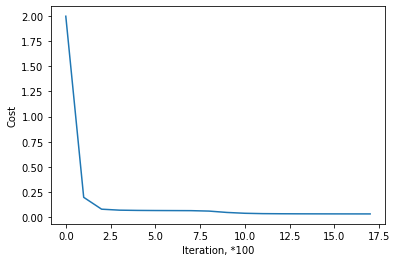

In [73]:
cls.fit(X, Y)

In [74]:
for parameter in cls.parameters:
    print("{} \t \n {} ".format(parameter, cls.parameters[parameter])) #cls.parameters[parameter].shape \t {} 

W_1 	 
 [[ -3.68438033   7.82492068  -1.97482228  -2.18992731]
 [ -0.98620296  -0.97297252  -1.29562453  -8.73870651]
 [  3.88175514  -0.08202598 -12.83849973  -0.74685022]
 [  0.67101523  -0.87663284   1.39264997   3.06463391]] 
b_1 	 
 [[3.12174392]
 [6.53919939]
 [6.72973255]
 [1.47167305]] 
W_2 	 
 [[ -1.77112567 -11.92104561   1.4517116    3.04295842]
 [  9.39226997   1.86792359  17.69995991  -6.5545089 ]
 [ -3.10908921   0.73272752  -2.09698115   5.19534964]] 
b_2 	 
 [[-0.79377911]
 [-6.06346738]
 [ 1.68019224]] 
W_3 	 
 [[ 1.92246024 -2.60874742  4.52380499]
 [-2.62473237  2.43032591 -7.76613634]
 [-5.45114016  6.44074193 -2.53773947]] 
b_3 	 
 [[-1.55084203]
 [ 1.21313902]
 [ 2.35746   ]] 
W_4 	 
 [[-5.8534207   7.72819488  2.52820684]
 [-0.16042477 -8.05172046  5.99350979]
 [ 6.0778457  -1.96894575 -9.52945436]] 
b_4 	 
 [[-2.67600807]
 [-0.2473179 ]
 [ 2.2724272 ]] 


In [75]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[9.99893564e-01, 1.06342040e-04, 9.37280358e-08],
       [9.99893002e-01, 1.06904195e-04, 9.41043691e-08],
       [9.99893471e-01, 1.06435119e-04, 9.37903930e-08],
       [9.99893306e-01, 1.06600301e-04, 9.39010101e-08],
       [9.99893667e-01, 1.06239359e-04, 9.36592243e-08],
       [9.99893305e-01, 1.06601066e-04, 9.39015226e-08],
       [9.99893472e-01, 1.06433914e-04, 9.37895862e-08],
       [9.99893472e-01, 1.06434412e-04, 9.37899193e-08],
       [9.99893185e-01, 1.06720605e-04, 9.39815384e-08],
       [9.99893406e-01, 1.06500172e-04, 9.38339639e-08],
       [9.99893597e-01, 1.06309776e-04, 9.37064162e-08],
       [9.99893513e-01, 1.06393505e-04, 9.37625164e-08],
       [9.99893381e-01, 1.06524827e-04, 9.38504751e-08],
       [9.99893667e-01, 1.06239629e-04, 9.36594053e-08],
       [9.99893752e-01, 1.06154865e-04, 9.36025842e-08],
       [9.99893713e-01, 1.06193279e-04, 9.36283367e-08],
       [9.99893490e-01, 1.06416696e-04, 9.37780524e-08],
       [9.99893356e-01, 1.06550

In [76]:
Y_hat = cls.predict(X) # отримуємо масив з 0 та 1 
Y_hat = np.array(lb.inverse_transform(Y_hat)) # перетворюємо в значення класу, до якого належить приклад
print(Y_hat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [77]:
custom_accuracy = accuracy_score(Y, Y_hat)
custom_accuracy

0.9933333333333333

# Scikit-learn Classifier

In [78]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000,  solver = 'adam') #, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [79]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(20,), max_iter=10000)

In [80]:
clf.predict_proba(X)

array([[9.96882629e-01, 3.11737090e-03, 3.53588255e-12],
       [9.91281546e-01, 8.71845356e-03, 6.31356820e-11],
       [9.94811401e-01, 5.18859894e-03, 2.44373220e-11],
       [9.89243317e-01, 1.07566832e-02, 1.76632455e-10],
       [9.97257574e-01, 2.74242576e-03, 2.97581051e-12],
       [9.95017253e-01, 4.98274683e-03, 5.04498864e-12],
       [9.93381841e-01, 6.61815896e-03, 4.43201619e-11],
       [9.94945508e-01, 5.05449167e-03, 1.38665889e-11],
       [9.86603574e-01, 1.33964253e-02, 4.29664242e-10],
       [9.93229167e-01, 6.77083293e-03, 4.00336728e-11],
       [9.97632164e-01, 2.36783573e-03, 1.08528488e-12],
       [9.92794660e-01, 7.20533952e-03, 4.57393985e-11],
       [9.93320386e-01, 6.67961444e-03, 4.59733237e-11],
       [9.95855684e-01, 4.14431590e-03, 3.10755507e-11],
       [9.99475604e-01, 5.24396483e-04, 1.34070903e-14],
       [9.98959843e-01, 1.04015651e-03, 6.11690207e-14],
       [9.98157072e-01, 1.84292832e-03, 4.32191828e-13],
       [9.95771273e-01, 4.22872

In [81]:
clf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [82]:
sk_accuracy = accuracy_score(Y, clf.predict(X))
sk_accuracy

0.98

In [83]:
print("Compare accuracy of custom and sklearn algorithm. \n")
res_compare_test = pd.DataFrame({'accuracy_custom' : [custom_accuracy], 'accuracy_sk' : [sk_accuracy], 'difference' : [abs(custom_accuracy - sk_accuracy)]})
print(res_compare_test)

Compare accuracy of custom and sklearn algorithm. 

   accuracy_custom  accuracy_sk  difference
0         0.993333         0.98    0.013333


In [84]:
clf.n_iter_

1097